In [1]:
!pip install kaggle --quiet
import os, shutil

# Create kaggle directory
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Search for kaggle.json
kaggle_found = False
for path in ["kaggle.json", "/content/kaggle.json", "./kaggle.json", "sample_data/kaggle.json"]:
    if os.path.exists(path):
        shutil.copy(path, f"{kaggle_dir}/kaggle.json")
        os.chmod(f"{kaggle_dir}/kaggle.json", 0o600)
        print("✓ Found and configured kaggle.json")
        kaggle_found = True
        break

if not kaggle_found:
    raise SystemExit("ERROR: Upload kaggle.json first!")

print("✓ kaggle.json verified at:", kaggle_dir)


✓ Found and configured kaggle.json
✓ kaggle.json verified at: /root/.kaggle


In [2]:
import kaggle
import os
import shutil
import pandas as pd
from pathlib import Path

kaggle.api.authenticate()

BASE_DIR = "emotion_datasets"
COMBINED_DIR = "combined_emotions"
METADATA_FILE = "dataset_metadata.csv"

DATASETS = {
    "crema_d": "ejlok1/cremad",
    "ravdess": "uwrfkaggler/ravdess-emotional-speech-audio",
    "savee": "ejlok1/surrey-audiovisual-expressed-emotion-savee",
    "tess": "ejlok1/toronto-emotional-speech-set-tess",
    "meld": "shivamburnwal/meld-dataset"
}

EMOTION_MAPPING = {
    "ANG": "angry", "DIS": "disgust", "FEA": "fear", "HAP": "happy", "NEU": "neutral", "SAD": "sad",
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fear",
    "07": "disgust", "08": "surprise",
    "a": "angry", "d": "disgust", "f": "fear", "h": "happy", "n": "neutral", "sa": "sad", "su": "surprise",
    "angry": "angry", "disgust": "disgust", "fear": "fear", "happy": "happy", "neutral": "neutral",
    "ps": "surprise", "sad": "sad",
    "anger": "angry", "joy": "happy", "sadness": "sad", "surprise": "surprise",
    "fear": "fear", "disgust": "disgust", "neutral": "neutral"
}


In [3]:
def parse_crema_d(name):
    parts = name.split("_")
    if len(parts) >= 3:
        return EMOTION_MAPPING.get(parts[2], "unknown")
    return "unknown"

def parse_ravdess(name):
    parts = name.split("-")
    if len(parts) >= 3:
        return EMOTION_MAPPING.get(parts[2], "unknown")
    return "unknown"

def parse_savee(name):
    parts = name.split("_")
    if len(parts) >= 2:
        code = ''.join([c for c in parts[1].replace(".wav", "") if c.isalpha()])
        return EMOTION_MAPPING.get(code, "unknown")
    return "unknown"

def parse_tess(name):
    parts = name.lower().split("_")
    if len(parts) >= 3:
        emotion = parts[2].replace(".wav", "")
        return EMOTION_MAPPING.get(emotion, "unknown")
    return "unknown"

def parse_meld(name):
    name = name.lower()
    for key, val in EMOTION_MAPPING.items():
        if key in name:
            return val
    return "unknown"

PARSERS = {
    "crema_d": parse_crema_d,
    "ravdess": parse_ravdess,
    "savee": parse_savee,
    "tess": parse_tess,
    "meld": parse_meld
}


In [5]:
def download_datasets():
    os.makedirs(BASE_DIR, exist_ok=True)
    print("Downloading datasets...\n")

    for name, ds in DATASETS.items():
        path = f"{BASE_DIR}/{name}"
        print(f"Downloading {name}...")
        try:
            kaggle.api.dataset_download_files(ds, path=path, unzip=True)
            print(f"✓ {name} downloaded\n")
        except Exception as e:
            print(f"✗ Failed {name}: {e}\n")

download_datasets()



Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
✓ crema_d downloaded

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
✓ ravdess downloaded

Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
✓ savee downloaded

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
✓ tess downloaded

Dataset URL: https://www.kaggle.com/datasets/shivamburnwal/meld-dataset
✗ Failed meld: 403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/download/shivamburnwal/meld-dataset?raw=false



In [6]:
def organize_datasets():
    os.makedirs(COMBINED_DIR, exist_ok=True)
    metadata = []
    count = 0

    for name, parser in PARSERS.items():
        path = f"{BASE_DIR}/{name}"
        print(f"Processing {name}...")

        audio_files = []
        for ext in [".wav", ".mp3", ".flac", ".m4a"]:
            audio_files.extend(Path(path).rglob(f"*{ext}"))

        print(f"  Found {len(audio_files)} files")

        for f in audio_files:
            emotion = parser(f.name)
            if emotion == "unknown":
                continue

            out_dir = f"{COMBINED_DIR}/{emotion}"
            os.makedirs(out_dir, exist_ok=True)

            new_name = f"{name}_{count:06d}_{f.name}"
            dest = f"{out_dir}/{new_name}"

            shutil.copy2(f, dest)

            metadata.append({
                "filename": new_name,
                "original_filename": f.name,
                "dataset": name,
                "emotion": emotion,
                "path": dest
            })
            count += 1

    df = pd.DataFrame(metadata)
    df.to_csv(f"{COMBINED_DIR}/{METADATA_FILE}", index=False)
    print(f"\n✓ Total files organized: {count}")
    return df

df = organize_datasets()


Processing crema_d...
  Found 2720 files
Processing ravdess...
  Found 2880 files
Processing savee...
  Found 480 files
Processing tess...
  Found 5600 files
Processing meld...
  Found 0 files

✓ Total files organized: 11680


In [7]:
print("Dataset Ready!")
print(f"Combined Folder: {COMBINED_DIR}")
print(f"Metadata File: {COMBINED_DIR}/{METADATA_FILE}")


Dataset Ready!
Combined Folder: combined_emotions
Metadata File: combined_emotions/dataset_metadata.csv


In [8]:
# Run this cell first in Colab / Jupyter (only once)
!pip install -q librosa tensorflow scikit-learn matplotlib tqdm seaborn

print("✓ Packages installed/available")


✓ Packages installed/available


In [9]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports done")


✓ Imports done


In [10]:
COMBINED_DIR = "combined_emotions"
METADATA_FILE = "dataset_metadata.csv"
MODEL_SAVE_PATH = "emotion_lstm_model.h5"
LABEL_ENCODER_PATH = "label_encoder.npy"

# Audio processing params
SAMPLE_RATE = 22050
DURATION = 3           # seconds to load per file
MAX_PAD_LEN = 130      # frames for MFCC (time steps)

# Model / training params
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

print("✓ Configuration set")


✓ Configuration set


In [11]:
def extract_features(file_path, max_pad_len=MAX_PAD_LEN, sr=SAMPLE_RATE, duration=DURATION):
    """
    Load audio (fixed duration) and extract 40 MFCCs.
    Returns a (max_pad_len, n_mfcc) array or None on failure.
    """
    try:
        audio, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = mfccs.T  # shape: (time_steps, n_mfcc)

        # pad or truncate
        if mfccs.shape[0] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[0]
            mfccs = np.pad(mfccs, pad_width=((0, pad_width), (0, 0)), mode='constant')
        else:
            mfccs = mfccs[:max_pad_len, :]

        return mfccs.astype(np.float32)
    except Exception as e:
        # optionally log: print("extract error", file_path, e)
        return None

print("✓ Feature extractor ready")


✓ Feature extractor ready


In [13]:
metadata_path = os.path.join(COMBINED_DIR, METADATA_FILE)
if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"Metadata not found: {metadata_path}. Run dataset combiner first.")

df = pd.read_csv(metadata_path)
print(f"Total files in metadata: {len(df)}")
print(df['emotion'].value_counts())

# Extract features
X = []
y = []

print("\nExtracting MFCCs: (this may take a while depending on #files)")
for _, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row['path'])
    if features is not None:
        X.append(features)
        y.append(row['emotion'])

X = np.array(X)
y = np.array(y)
print(f"\n✓ Extracted features from {len(X)} files")
print("Feature array shape:", X.shape)


Total files in metadata: 11680
emotion
happy       1709
disgust     1709
angry       1709
fear        1709
sad         1708
neutral     1508
surprise    1244
calm         384
Name: count, dtype: int64

Extracting MFCCs: (this may take a while depending on #files)


100%|██████████| 11680/11680 [02:30<00:00, 77.84it/s]



✓ Extracted features from 11680 files
Feature array shape: (11680, 130, 40)


In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Save classes (useful for later inference)
np.save(LABEL_ENCODER_PATH, le.classes_, allow_pickle=True)
print("✓ Label encoder classes saved to", LABEL_ENCODER_PATH)
print("Label mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")


✓ Label encoder classes saved to label_encoder.npy
Label mapping:
  0: angry
  1: calm
  2: disgust
  3: fear
  4: happy
  5: neutral
  6: sad
  7: surprise


In [15]:
# stratify by class indices
y_indices = y_categorical.argmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.20, random_state=42, stratify=y_indices
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train.argmax(axis=1)
)

print("Dataset split:")
print("  Train:", X_train.shape[0])
print("  Val:  ", X_val.shape[0])
print("  Test: ", X_test.shape[0])


Dataset split:
  Train: 7942
  Val:   1402
  Test:  2336


In [16]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, n_mfcc)
num_classes = y_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=input_shape),

    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),

    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.3),

    layers.LSTM(32),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 130, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 130, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,984 (589.78 KB)

 Trainable params: 150,984 (589.78 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save final model (ModelCheckpoint already saved best)
model.save(MODEL_SAVE_PATH)
print("✓ Model saved to", MODEL_SAVE_PATH)


Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2465 - loss: 1.8907
Epoch 1: val_accuracy improved from -inf to 0.51213, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.2468 - loss: 1.8900 - val_accuracy: 0.5121 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4567 - loss: 1.3724
Epoch 2: val_accuracy improved from 0.51213 to 0.57703, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4568 - loss: 1.3721 - val_accuracy: 0.5770 - val_loss: 1.0789 - learning_rate: 0.0010
Epoch 3/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5113 - loss: 1.2202
Epoch 3: val_accuracy improved from 0.57703 to 0.62054, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5115 - loss: 1.2201 - val_accuracy: 0.6205 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 4/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5835 - loss: 1.0738
Epoch 4: val_accuracy did not improve from 0.62054
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5835 - loss: 1.0736 - val_accuracy: 0.6191 - val_loss: 0.9292 - learning_rate: 0.0010
Epoch 5/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6007 - loss: 0.9737
Epoch 5: val_accuracy improved from 0.62054 to 0.64194, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6008 - loss: 0.9736 - val_accuracy: 0.6419 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 6/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6124 - loss: 0.9730
Epoch 6: val_accuracy did not improve from 0.64194
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6123 - loss: 0.9734 - val_accuracy: 0.6355 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6111 - loss: 0.9539
Epoch 7: val_accuracy improved from 0.64194 to 0.65121, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6111 - loss: 0.9538 - val_accuracy: 0.6512 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 8/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6385 - loss: 0.8997
Epoch 8: val_accuracy improved from 0.65121 to 0.66976, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6385 - loss: 0.8996 - val_accuracy: 0.6698 - val_loss: 0.8292 - learning_rate: 0.0010
Epoch 9/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6478 - loss: 0.8580
Epoch 9: val_accuracy improved from 0.66976 to 0.67475, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6479 - loss: 0.8580 - val_accuracy: 0.6748 - val_loss: 0.8230 - learning_rate: 0.0010
Epoch 10/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6781 - loss: 0.8238
Epoch 10: val_accuracy improved from 0.67475 to 0.73252, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6781 - loss: 0.8238 - val_accuracy: 0.7325 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 11/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7079 - loss: 0.7760
Epoch 11: val_accuracy improved from 0.73252 to 0.73894, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7078 - loss: 0.7762 - val_accuracy: 0.7389 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 12/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7083 - loss: 0.7830
Epoch 12: val_accuracy improved from 0.73894 to 0.74394, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7083 - loss: 0.7832 - val_accuracy: 0.7439 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 13/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7200 - loss: 0.7547
Epoch 13: val_accuracy improved from 0.74394 to 0.75749, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7201 - loss: 0.7545 - val_accuracy: 0.7575 - val_loss: 0.6594 - learning_rate: 0.0010
Epoch 14/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7278 - loss: 0.7187
Epoch 14: val_accuracy improved from 0.75749 to 0.76177, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7278 - loss: 0.7188 - val_accuracy: 0.7618 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 15/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7484 - loss: 0.6651
Epoch 15: val_accuracy did not improve from 0.76177
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7484 - loss: 0.6651 - val_accuracy: 0.7539 - val_loss: 0.6691 - learning_rate: 0.0010
Epoch 16/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7540 - loss: 0.6573
Epoch 16: val_accuracy did not improve from 0.76177
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7540 - loss: 0.6572 - val_accuracy: 0.7568 - val_loss: 0.7151 - learning_rate: 0.0010
Epoch 17/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7443 - loss: 0.7087
Epoch 17: val_accuracy improved from 0.76177 to 0.77389, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7444 - loss: 0.7085 - val_accuracy: 0.7739 - val_loss: 0.6182 - learning_rate: 0.0010
Epoch 18/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7611 - loss: 0.6634
Epoch 18: val_accuracy did not improve from 0.77389
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7610 - loss: 0.6635 - val_accuracy: 0.7589 - val_loss: 0.6494 - learning_rate: 0.0010
Epoch 19/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7603 - loss: 0.6504
Epoch 19: val_accuracy improved from 0.77389 to 0.77532, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7603 - loss: 0.6503 - val_accuracy: 0.7753 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 20/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7790 - loss: 0.6031
Epoch 20: val_accuracy did not improve from 0.77532
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7789 - loss: 0.6033 - val_accuracy: 0.7753 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 21/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7386 - loss: 0.7393
Epoch 21: val_accuracy did not improve from 0.77532
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7386 - loss: 0.7392 - val_accuracy: 0.7675 - val_loss: 0.6558 - learning_rate: 0.0010
Epoch 22/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7778 - loss: 0.6190
Epoch 22: val_accuracy improved from 0.77532 to 0.78031, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7778 - loss: 0.6191 - val_accuracy: 0.7803 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 23/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7850 - loss: 0.5828
Epoch 23: val_accuracy did not improve from 0.78031
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7850 - loss: 0.5828 - val_accuracy: 0.7782 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 24/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7787 - loss: 0.5997
Epoch 24: val_accuracy improved from 0.78031 to 0.78174, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7787 - loss: 0.5998 - val_accuracy: 0.7817 - val_loss: 0.6083 - learning_rate: 0.0010
Epoch 25/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7785 - loss: 0.6117
Epoch 25: val_accuracy improved from 0.78174 to 0.78602, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7785 - loss: 0.6118 - val_accuracy: 0.7860 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 26/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7837 - loss: 0.5898
Epoch 26: val_accuracy improved from 0.78602 to 0.79458, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7838 - loss: 0.5897 - val_accuracy: 0.7946 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 27/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7966 - loss: 0.5568
Epoch 27: val_accuracy did not improve from 0.79458
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7967 - loss: 0.5567 - val_accuracy: 0.7825 - val_loss: 0.6123 - learning_rate: 0.0010
Epoch 28/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7885 - loss: 0.5529
Epoch 28: val_accuracy did not improve from 0.79458
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7886 - loss: 0.5528 - val_accuracy: 0.7903 - val_loss: 0.6227 - learning_rate: 0.0010
Epoch 29/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8042 - loss: 0.5501
Epoch 29: val_accuracy improved from 0.79458 to 0.80100, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8042 - loss: 0.5501 - val_accuracy: 0.8010 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 30/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8093 - loss: 0.5258
Epoch 30: val_accuracy did not improve from 0.80100
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8093 - loss: 0.5259 - val_accuracy: 0.7839 - val_loss: 0.6075 - learning_rate: 0.0010
Epoch 31/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8129 - loss: 0.5121
Epoch 31: val_accuracy did not improve from 0.80100
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8129 - loss: 0.5122 - val_accuracy: 0.7967 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 32/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8008 - loss: 0.5643
Epoch 32: val_accuracy improved from 0.80100 to 0.80243, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8008 - loss: 0.5641 - val_accuracy: 0.8024 - val_loss: 0.5751 - learning_rate: 0.0010
Epoch 33/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8212 - loss: 0.5056
Epoch 33: val_accuracy did not improve from 0.80243
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8212 - loss: 0.5056 - val_accuracy: 0.7639 - val_loss: 0.7559 - learning_rate: 0.0010
Epoch 34/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8002 - loss: 0.5888
Epoch 34: val_accuracy improved from 0.80243 to 0.81384, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8002 - loss: 0.5887 - val_accuracy: 0.8138 - val_loss: 0.5511 - learning_rate: 0.0010
Epoch 35/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8246 - loss: 0.4901
Epoch 35: val_accuracy did not improve from 0.81384
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8246 - loss: 0.4901 - val_accuracy: 0.7924 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 36/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8343 - loss: 0.4579
Epoch 36: val_accuracy did not improve from 0.81384
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8343 - loss: 0.4579 - val_accuracy: 0.7932 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 37/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8214 - loss: 0.4901
Epoch 37: val_accuracy did not improve from 0.81384
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8215 - loss: 0.4900 - val_accuracy: 0.8046 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 38/50


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8449 - loss: 0.4414 - val_accuracy: 0.8167 - val_loss: 0.5662 - learning_rate: 0.0010
Epoch 43/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8549 - loss: 0.4055
Epoch 43: val_accuracy improved from 0.81669 to 0.81883, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8549 - loss: 0.4054 - val_accuracy: 0.8188 - val_loss: 0.5716 - learning_rate: 5.0000e-04
Epoch 44/50
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8663 - loss: 0.3746
Epoch 44: val_accuracy did not improve from 0.81883
249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8663 - loss: 0.3746 - val_accuracy: 0.8174 - val_loss: 0.5789 - learning_rate: 5.0000e-04
Epoch 45/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8623 - loss: 0.3733
Epoch 45: val_accuracy did not improve from 0.81883
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8623 - loss: 0.3733 - val_accuracy: 0.8167 - val_loss: 0.5881 - learning_rate: 5.0000e-04
Epoch 46/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8681 - loss: 0.3646
Epoch 46: val_accuracy improved from 0.81883 to 0.82596, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8682 - loss: 0.3645 - val_accuracy: 0.8260 - val_loss: 0.5821 - learning_rate: 5.0000e-04
Epoch 47/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8746 - loss: 0.3536
Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 47: val_accuracy improved from 0.82596 to 0.82668, saving model to emotion_lstm_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8746 - loss: 0.3535 - val_accuracy: 0.8267 - val_loss: 0.5783 - learning_rate: 5.0000e-04
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 37.


✓ Model saved to emotion_lstm_model.h5


In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions & report
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion matrix:\n", cm)


Test loss: 0.5742
Test accuracy: 0.8129 (81.29%)

Classification report:
              precision    recall  f1-score   support

       angry       0.92      0.82      0.87       342
        calm       0.82      0.82      0.82        77
     disgust       0.77      0.81      0.79       342
        fear       0.88      0.66      0.76       342
       happy       0.80      0.78      0.79       342
     neutral       0.77      0.89      0.82       301
         sad       0.71      0.84      0.77       341
    surprise       0.92      0.94      0.93       249

    accuracy                           0.81      2336
   macro avg       0.82      0.82      0.82      2336
weighted avg       0.82      0.81      0.81      2336


Confusion matrix:
 [[281   4  22   5  21   4   2   3]
 [  0  63   3   0   1   4   6   0]
 [  7   3 276   4  12  17  23   0]
 [ 12   0  15 227  16  13  55   4]
 [  7   0  14  11 266  23   8  13]
 [  0   2   9   0   3 267  20   0]
 [  0   5  17   7   6  20 286   0]
 [  0   0  

✓ Saved training_history.png


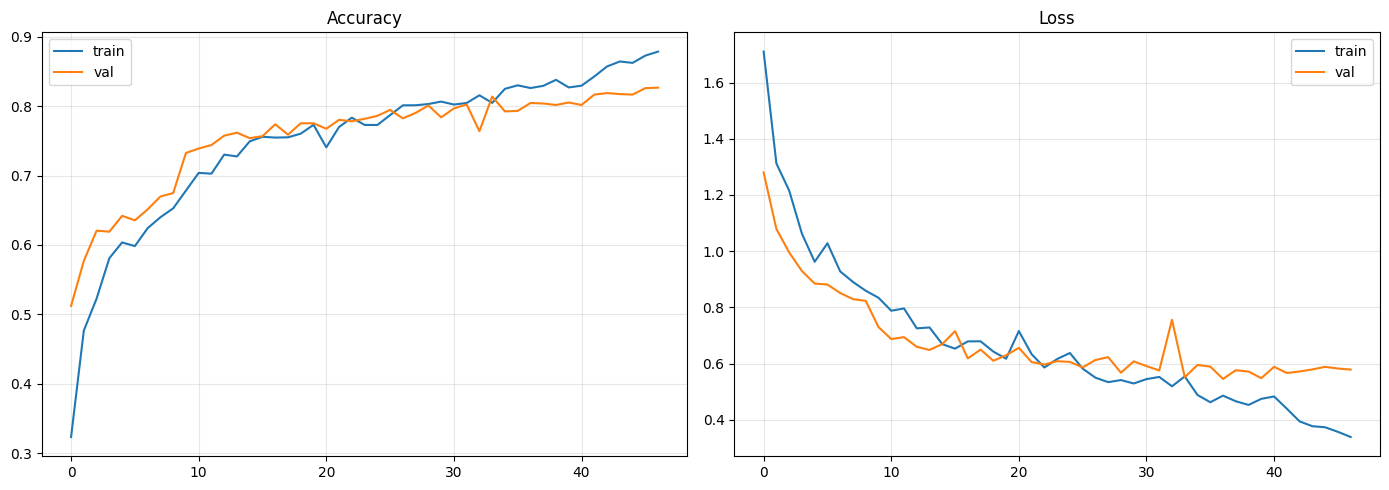

✓ Saved confusion_matrix.png


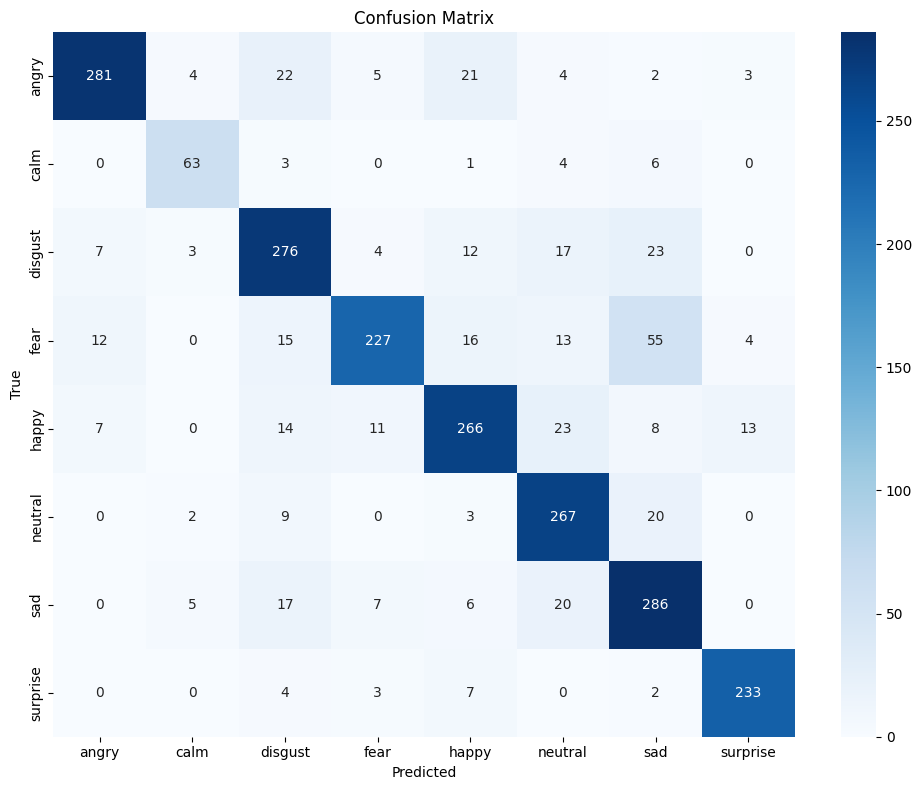

In [19]:
import seaborn as sns

# Training history plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='val')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='val')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Saved training_history.png")
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved confusion_matrix.png")
plt.show()


Starting hyperparameter search...
This will take a while. Grab a coffee! ☕

STARTING RANDOMIZED SEARCH - 20 iterations

ITERATION 1/20

Hyperparameters:
  lstm_units_1        : 128
  lstm_units_2        : 256
  lstm_units_3        : 32
  dropout_lstm        : 0.4
  dropout_dense       : 0.6
  dense_units         : 128
  learning_rate       : 0.0003
  batch_size          : 64

Results:
  Val Accuracy: 0.7989 (79.89%)
  Val Loss:     0.6044
  ✓ NEW BEST MODEL! Accuracy: 0.7989

ITERATION 2/20

Hyperparameters:
  lstm_units_1        : 256
  lstm_units_2        : 256
  lstm_units_3        : 64
  dropout_lstm        : 0.6
  dropout_dense       : 0.6
  dense_units         : 64
  learning_rate       : 0.0005
  batch_size          : 128

Results:
  Val Accuracy: 0.8210 (82.10%)
  Val Loss:     0.5865
  ✓ NEW BEST MODEL! Accuracy: 0.8210

ITERATION 3/20

Hyperparameters:
  lstm_units_1        : 256
  lstm_units_2        : 256
  lstm_units_3        : 32
  dropout_lstm        : 0.4
  dropout_dens

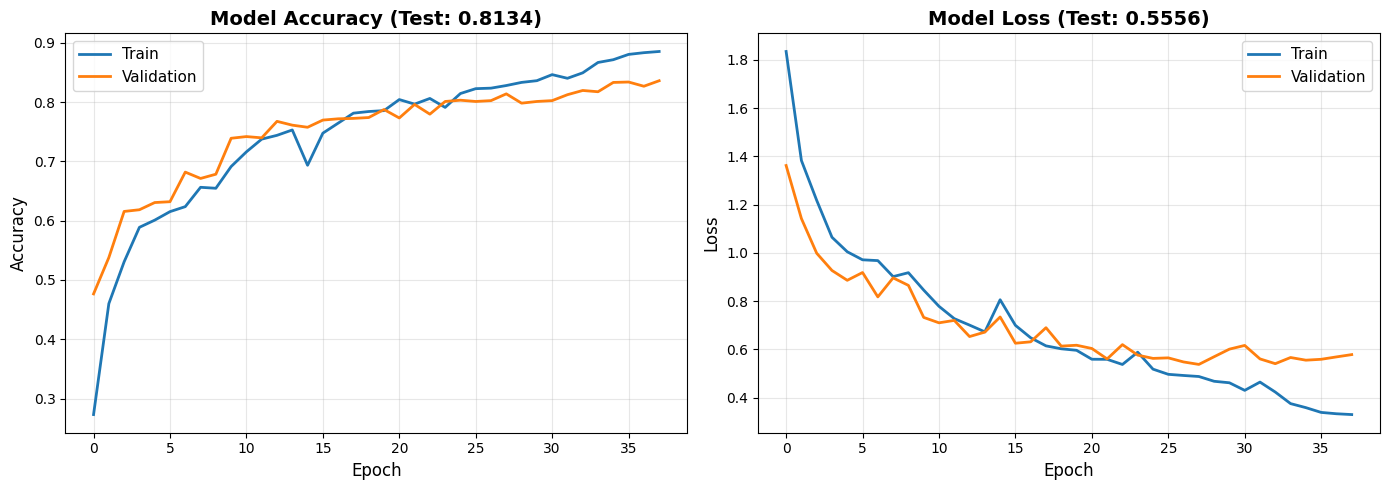

✓ Training history displayed


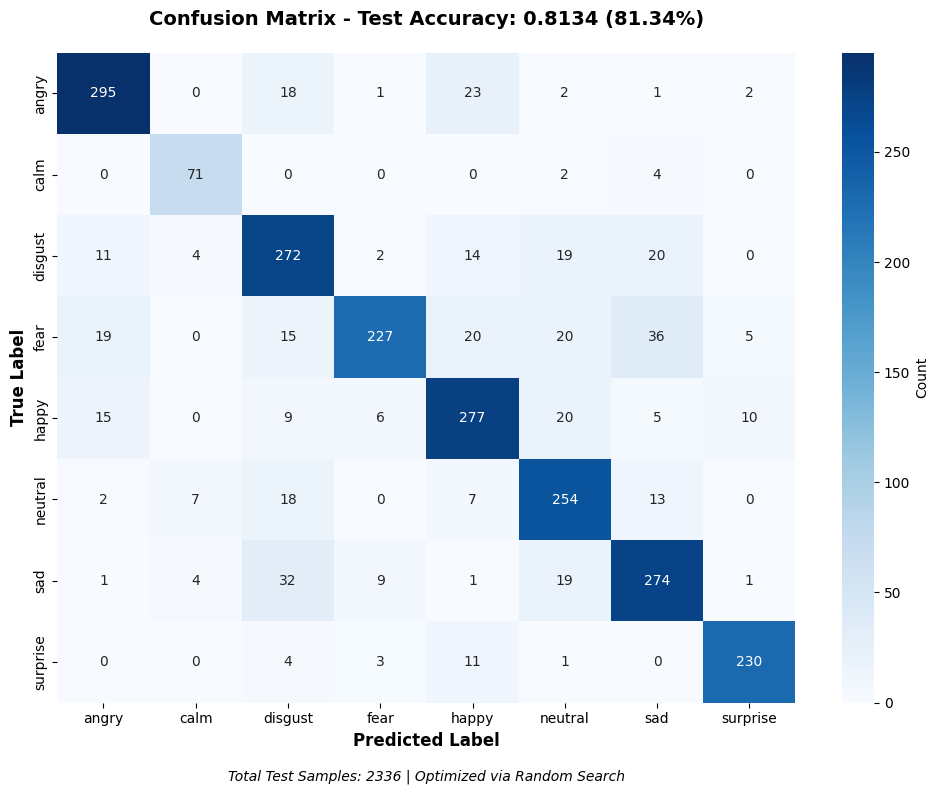

✓ Confusion matrix displayed


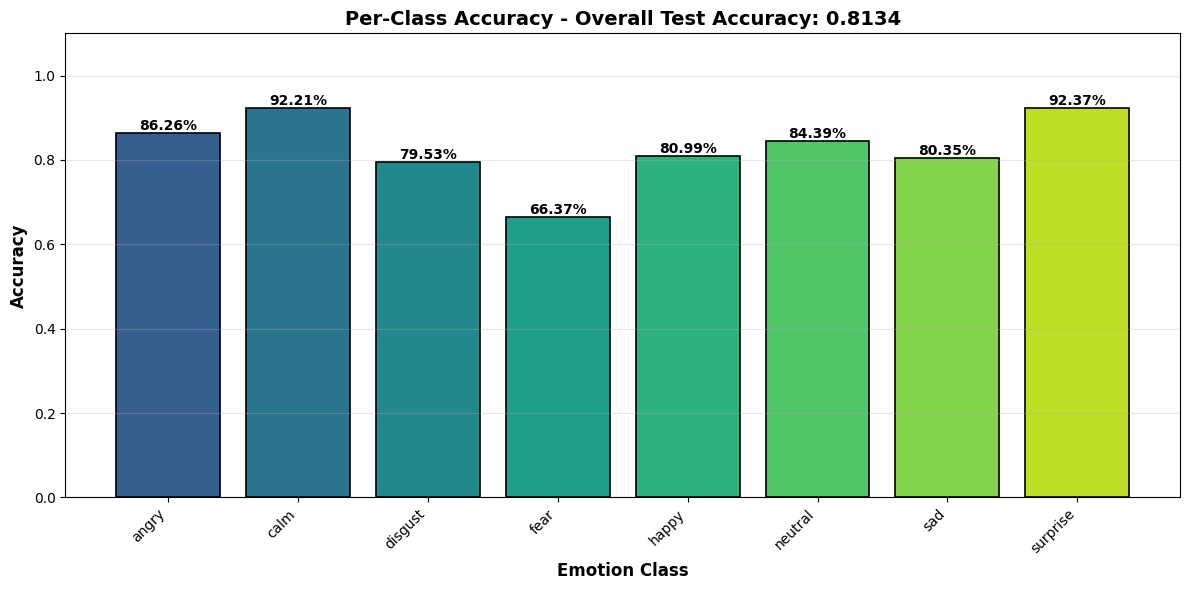

✓ Per-class accuracy displayed

✓ ALL VISUALIZATIONS COMPLETE!


In [24]:
# ============================================
# CELL 1: RANDOMIZED HYPERPARAMETER SEARCH
# ============================================

import random
import json
from datetime import datetime

# Define hyperparameter search space

PARAM_SPACE = {
    # CHANGED: Added back 128 for more exploration
    'lstm_units_1': [128, 256],  # Was: [256]
    # Reason: Include 128 for lighter models, 256 for capacity
    # Smaller models (128) may generalize better and reduce overfitting

    # CHANGED: Focus more on 128 (most stable)
    'lstm_units_2': [128, 256],  # UNCHANGED from previous
    # Reason: 128 appeared in top models consistently

    # CHANGED: Keep 32-64 (smaller = less overfitting)
    'lstm_units_3': [32, 64],  # UNCHANGED from previous
    # Reason: Smaller final LSTM prevents memorization

    # CHANGED: Strong regularization range
    'dropout_lstm': [0.4, 0.5, 0.6],  # UNCHANGED from previous
    # Reason: 0.4 minimum to prevent overfitting, 0.6 for aggressive regularization

    # CHANGED: High dropout for dense layer
    'dropout_dense': [0.5, 0.6],  # UNCHANGED from previous
    # Reason: Dense layer needs strong dropout to prevent overfitting

    # CHANGED: Small to medium dense layers only
    'dense_units': [32, 64, 128],  # UNCHANGED from previous
    # Reason: Removed 256 (too large, causes overfitting)

    # CHANGED: Added 0.0003 back for more exploration
    'learning_rate': [0.0003, 0.0005],  # Was: [0.0005]
    # Reason: 0.0005 is best, but 0.0003 provides slower, more stable training
    # Removed 0.001 (too aggressive, causes overfitting)

    # CHANGED: Added 64 back for comparison
    'batch_size': [64, 128],  # Was: [128]
    # Reason: 128 generalizes better, but 64 might work with smaller models
    # Smaller batches add noise = regularization effect
}

def create_model_with_params(input_shape, num_classes, params):
    """Create model with given hyperparameters"""
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.LSTM(params['lstm_units_1'], return_sequences=True),
        layers.Dropout(params['dropout_lstm']),

        layers.LSTM(params['lstm_units_2'], return_sequences=True),
        layers.Dropout(params['dropout_lstm']),

        layers.LSTM(params['lstm_units_3']),
        layers.Dropout(params['dropout_lstm']),

        layers.Dense(params['dense_units'], activation='relu'),
        layers.Dropout(params['dropout_dense']),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def random_search(X_train, y_train, X_val, y_val, n_iterations=20):
    """
    Perform randomized hyperparameter search

    Args:
        n_iterations: Number of random configurations to try

    Returns:
        best_params, best_accuracy, all_results
    """
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]

    results = []
    best_accuracy = 0
    best_params = None
    best_model = None

    print("=" * 80)
    print(f"STARTING RANDOMIZED SEARCH - {n_iterations} iterations")
    print("=" * 80)

    for iteration in range(n_iterations):
        print(f"\n{'='*80}")
        print(f"ITERATION {iteration + 1}/{n_iterations}")
        print(f"{'='*80}")

        # Sample random hyperparameters
        params = {
            'lstm_units_1': random.choice(PARAM_SPACE['lstm_units_1']),
            'lstm_units_2': random.choice(PARAM_SPACE['lstm_units_2']),
            'lstm_units_3': random.choice(PARAM_SPACE['lstm_units_3']),
            'dropout_lstm': random.choice(PARAM_SPACE['dropout_lstm']),
            'dropout_dense': random.choice(PARAM_SPACE['dropout_dense']),
            'dense_units': random.choice(PARAM_SPACE['dense_units']),
            'learning_rate': random.choice(PARAM_SPACE['learning_rate']),
            'batch_size': random.choice(PARAM_SPACE['batch_size']),
        }

        print("\nHyperparameters:")
        for key, val in params.items():
            print(f"  {key:20s}: {val}")

        # Create and train model
        model = create_model_with_params(input_shape, num_classes, params)

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True,
                verbose=0
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-7,
                verbose=0
            )
        ]

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=params['batch_size'],
            epochs=40,  # Reduced for faster search
            callbacks=callbacks,
            verbose=0
        )

        # Get best validation accuracy
        val_accuracy = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])

        print(f"\nResults:")
        print(f"  Val Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"  Val Loss:     {val_loss:.4f}")

        # Store results
        result = {
            'iteration': iteration + 1,
            'params': params.copy(),
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'epochs_trained': len(history.history['val_accuracy'])
        }
        results.append(result)

        # Update best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.copy()
            best_model = model
            print(f"  ✓ NEW BEST MODEL! Accuracy: {best_accuracy:.4f}")

        # Clean up
        del model
        keras.backend.clear_session()

    print("\n" + "=" * 80)
    print("SEARCH COMPLETE!")
    print("=" * 80)
    print(f"\nBest Validation Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    print("\nBest Hyperparameters:")
    for key, val in best_params.items():
        print(f"  {key:20s}: {val}")

    # Save search results
    with open('hyperparameter_search_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    print("\n✓ Search results saved to hyperparameter_search_results.json")

    return best_params, best_accuracy, best_model, results

# Run randomized search (adjust n_iterations as needed)
print("Starting hyperparameter search...")
print("This will take a while. Grab a coffee! ☕\n")

best_params, best_val_acc, best_model, search_results = random_search(
    X_train, y_train,
    X_val, y_val,
    n_iterations=20  # Increase for better results (e.g., 30-50)
)

# Display top 5 configurations
print("\n" + "=" * 80)
print("TOP 5 CONFIGURATIONS")
print("=" * 80)
sorted_results = sorted(search_results, key=lambda x: x['val_accuracy'], reverse=True)
for i, result in enumerate(sorted_results[:5], 1):
    print(f"\n{i}. Accuracy: {result['val_accuracy']:.4f} ({result['val_accuracy']*100:.2f}%)")
    print(f"   Params: LSTM[{result['params']['lstm_units_1']}, "
          f"{result['params']['lstm_units_2']}, {result['params']['lstm_units_3']}], "
          f"Dense={result['params']['dense_units']}, "
          f"LR={result['params']['learning_rate']}, "
          f"Batch={result['params']['batch_size']}")

# Train final model with best parameters on full training data
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("=" * 80)

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

final_model = create_model_with_params(input_shape, num_classes, best_params)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=best_params['batch_size'],
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\n{'='*80}")
print(f"FINAL TEST RESULTS")
print(f"{'='*80}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions
y_pred = final_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true_classes, y_pred_classes)

# Store for saving in next cell
model = final_model
history = final_history
test_acc = test_accuracy

print(f"\n✓ Model ready to save with accuracy: {test_accuracy:.4f}")

# ============================================
# VISUALIZATIONS
# ============================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Training History Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(final_history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(final_history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title(f'Model Accuracy (Test: {test_accuracy:.4f})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Loss plot
axes[1].plot(final_history.history['loss'], label='Train', linewidth=2)
axes[1].plot(final_history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title(f'Model Loss (Test: {test_loss:.4f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Training history displayed")

# 2. Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)',
          fontsize=14, fontweight='bold', pad=20)

# Add accuracy text on plot
plt.text(
    0.5, -0.12,
    f'Total Test Samples: {len(y_test)} | Optimized via Random Search',
    ha='center',
    transform=plt.gca().transAxes,
    fontsize=10,
    style='italic'
)

plt.tight_layout()
plt.show()
print("✓ Confusion matrix displayed")

# 3. Per-class Performance Bar Chart
class_accuracies = []
class_names = []
for i, emotion in enumerate(le.classes_):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    class_accuracies.append(class_acc)
    class_names.append(emotion)

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(class_names)))
bars = plt.bar(class_names, class_accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2%}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Emotion Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title(f'Per-Class Accuracy - Overall Test Accuracy: {test_accuracy:.4f}',
          fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("✓ Per-class accuracy displayed")

print("\n" + "=" * 80)
print("✓ ALL VISUALIZATIONS COMPLETE!")
print("=" * 80)


SAVING MODEL AND RESULTS

✓ Model saved: emotion_model_acc_0_8134_20251123_141356.h5
✓ Parameters saved: best_params_acc_0_8134_20251123_141356.json
✓ Training history saved: training_history_acc_0_8134_20251123_141356.png


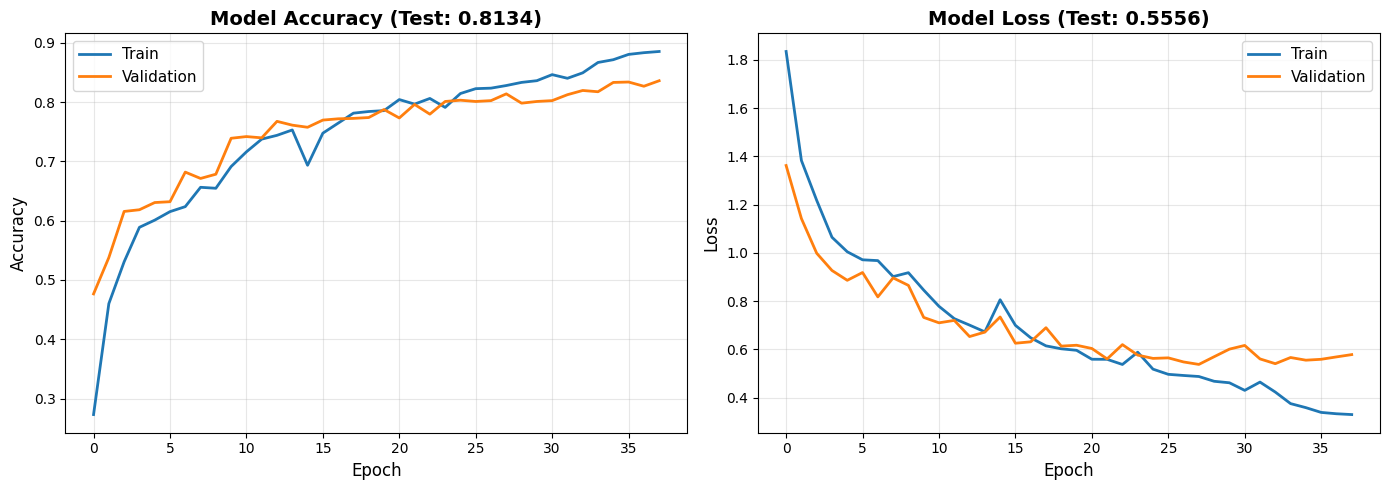

✓ Confusion matrix saved: confusion_matrix_acc_0_8134_20251123_141356.png


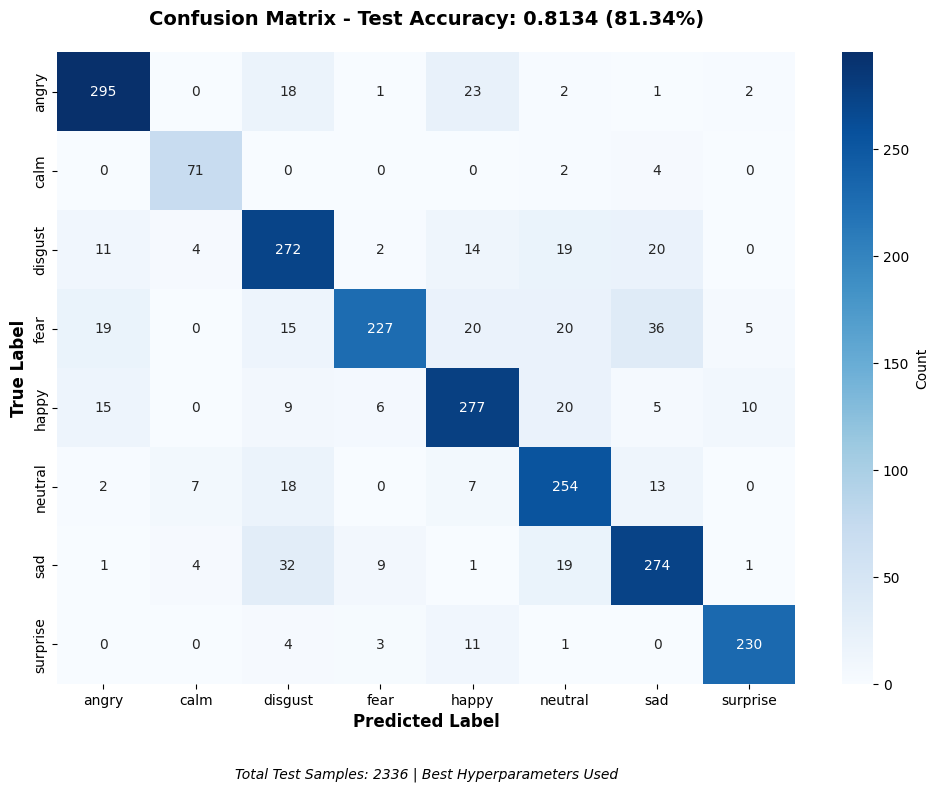


PER-CLASS PERFORMANCE
angry       : 0.8626 (86.26%) - 295/342 correct
calm        : 0.9221 (92.21%) - 71/77 correct
disgust     : 0.7953 (79.53%) - 272/342 correct
fear        : 0.6637 (66.37%) - 227/342 correct
happy       : 0.8099 (80.99%) - 277/342 correct
neutral     : 0.8439 (84.39%) - 254/301 correct
sad         : 0.8035 (80.35%) - 274/341 correct
surprise    : 0.9237 (92.37%) - 230/249 correct

SUMMARY
Test Accuracy:  0.8134 (81.34%)
Test Loss:      0.5556

Saved files:
  • emotion_model_acc_0_8134_20251123_141356.h5
  • best_params_acc_0_8134_20251123_141356.json
  • training_history_acc_0_8134_20251123_141356.png
  • confusion_matrix_acc_0_8134_20251123_141356.png

✓ All results saved successfully!

BEST HYPERPARAMETERS USED
  lstm_units_1        : 256
  lstm_units_2        : 256
  lstm_units_3        : 32
  dropout_lstm        : 0.4
  dropout_dense       : 0.5
  dense_units         : 64
  learning_rate       : 0.0005
  batch_size          : 64

COMPLETE! 🎉


In [25]:
# ============================================
# CELL 2: SAVE MODEL AND RESULTS WITH ACCURACY IN FILENAME
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Get test accuracy (should be available from previous cell)
# If running this cell standalone, evaluate first:
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Format accuracy for filename (4 decimal places)
acc_str = f"{test_acc:.4f}".replace('.', '_')
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filenames with accuracy
model_filename = f"emotion_model_acc_{acc_str}_{timestamp}.h5"
history_filename = f"training_history_acc_{acc_str}_{timestamp}.png"
confusion_filename = f"confusion_matrix_acc_{acc_str}_{timestamp}.png"
params_filename = f"best_params_acc_{acc_str}_{timestamp}.json"

print("=" * 80)
print("SAVING MODEL AND RESULTS")
print("=" * 80)

# 1. Save the model
model.save(model_filename)
print(f"\n✓ Model saved: {model_filename}")

# 2. Save best hyperparameters
import json
save_params = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'best_hyperparameters': best_params,
    'timestamp': timestamp
}

with open(params_filename, 'w') as f:
    json.dump(save_params, f, indent=2)
print(f"✓ Parameters saved: {params_filename}")

# 3. Save training history plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title(f'Model Accuracy (Test: {test_acc:.4f})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title(f'Model Loss (Test: {test_loss:.4f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(history_filename, dpi=300, bbox_inches='tight')
print(f"✓ Training history saved: {history_filename}")
plt.show()

# 4. Save confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)',
          fontsize=14, fontweight='bold', pad=20)

# Add accuracy text on plot
plt.text(
    0.5, -0.15,
    f'Total Test Samples: {len(y_test)} | Best Hyperparameters Used',
    ha='center',
    transform=plt.gca().transAxes,
    fontsize=10,
    style='italic'
)

plt.tight_layout()
plt.savefig(confusion_filename, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved: {confusion_filename}")
plt.show()

# 5. Print per-class accuracy
print("\n" + "=" * 80)
print("PER-CLASS PERFORMANCE")
print("=" * 80)
for i, emotion in enumerate(le.classes_):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"{emotion:12s}: {class_acc:.4f} ({class_acc*100:.2f}%) - {class_correct}/{class_total} correct")

# 6. Summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss:      {test_loss:.4f}")
print(f"\nSaved files:")
print(f"  • {model_filename}")
print(f"  • {params_filename}")
print(f"  • {history_filename}")
print(f"  • {confusion_filename}")
print(f"\n✓ All results saved successfully!")

# Optional: Display best hyperparameters
print("\n" + "=" * 80)
print("BEST HYPERPARAMETERS USED")
print("=" * 80)
for param, value in best_params.items():
    print(f"  {param:20s}: {value}")

print("\n" + "=" * 80)
print("COMPLETE! 🎉")
print("=" * 80)